In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [2]:
#Generate Morgan fingerprints for compounds
compound = []
smile = []
compound_df = pd.read_csv('./1443_admet_select.csv')

compound_df.insert(0, 'index', range(1, len(compound_df) + 1))

for _, number, smiles in compound_df[["index", "standardized_smiles"]].itertuples():
    compound.append((number, Chem.MolFromSmiles(smiles)))
    smile.append((number, smiles))


gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fps = [gen.GetFingerprint(x) for id, x in compound]


In [3]:
def clusterfps(fps, cutoff=0.7):
    #Cluster function
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1-x for x in sims])
    
    cs = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    cs = sorted(cs, key=len, reverse=True)
    return cs

In [27]:
cluster = clusterfps(fps, cutoff=0.6)
print("Number of clusters:", len(cluster))
print("Number of molecules in largest cluster:", len(cluster[0]))

Number of clusters: 275
Number of molecules in largest cluster: 45


In [ ]:
#Export cluster results to CSV
results = []
for cluster_id, cluster in enumerate(cluster):
    members_sorted = sorted(cluster)
    for member_idx in members_sorted:
        mol_id = compound[member_idx][0]
        smiles = smile[member_idx][1]
        results.append({
            'cluster_id': cluster_id+1,
            'member_idx': member_idx+1,
            'mol_id': mol_id,
            'smiles': smiles
        })
results_df = pd.DataFrame(results)
results_df.to_csv('./cluster_results.csv', index=False)

In [36]:
cluster = clusterfps(fps, cutoff=0.6)
print("Number of clusters:", len(cluster))
print("Number of molecules in largest cluster:", len(cluster[0]))

Number of clusters: 275
Number of molecules in largest cluster: 45


In [ ]:
#Export cluster representative molecules(best PharmFit score)
cluster_first = []
for i in range(len(cluster)):
    cluster[i] = np.sort(cluster[i])
    list2 = [smile[x][1] for x in cluster[i]]
    cluster_first.append(list2[0])
cluster_first_df = pd.DataFrame(cluster_first, columns=['standardized_smiles'])
df_map = pd.read_csv('./1443_admet_select.csv')
cluster_select = cluster_first_df.merge(df_map, on = 'standardized_smiles', how = 'left')
cluster_select.to_csv('./1443_clsuter_select.csv', index=False)

In [40]:
cluster_select['vina_title'].to_csv('./1443_cluster_vinatitle.txt', index=False, header=False)

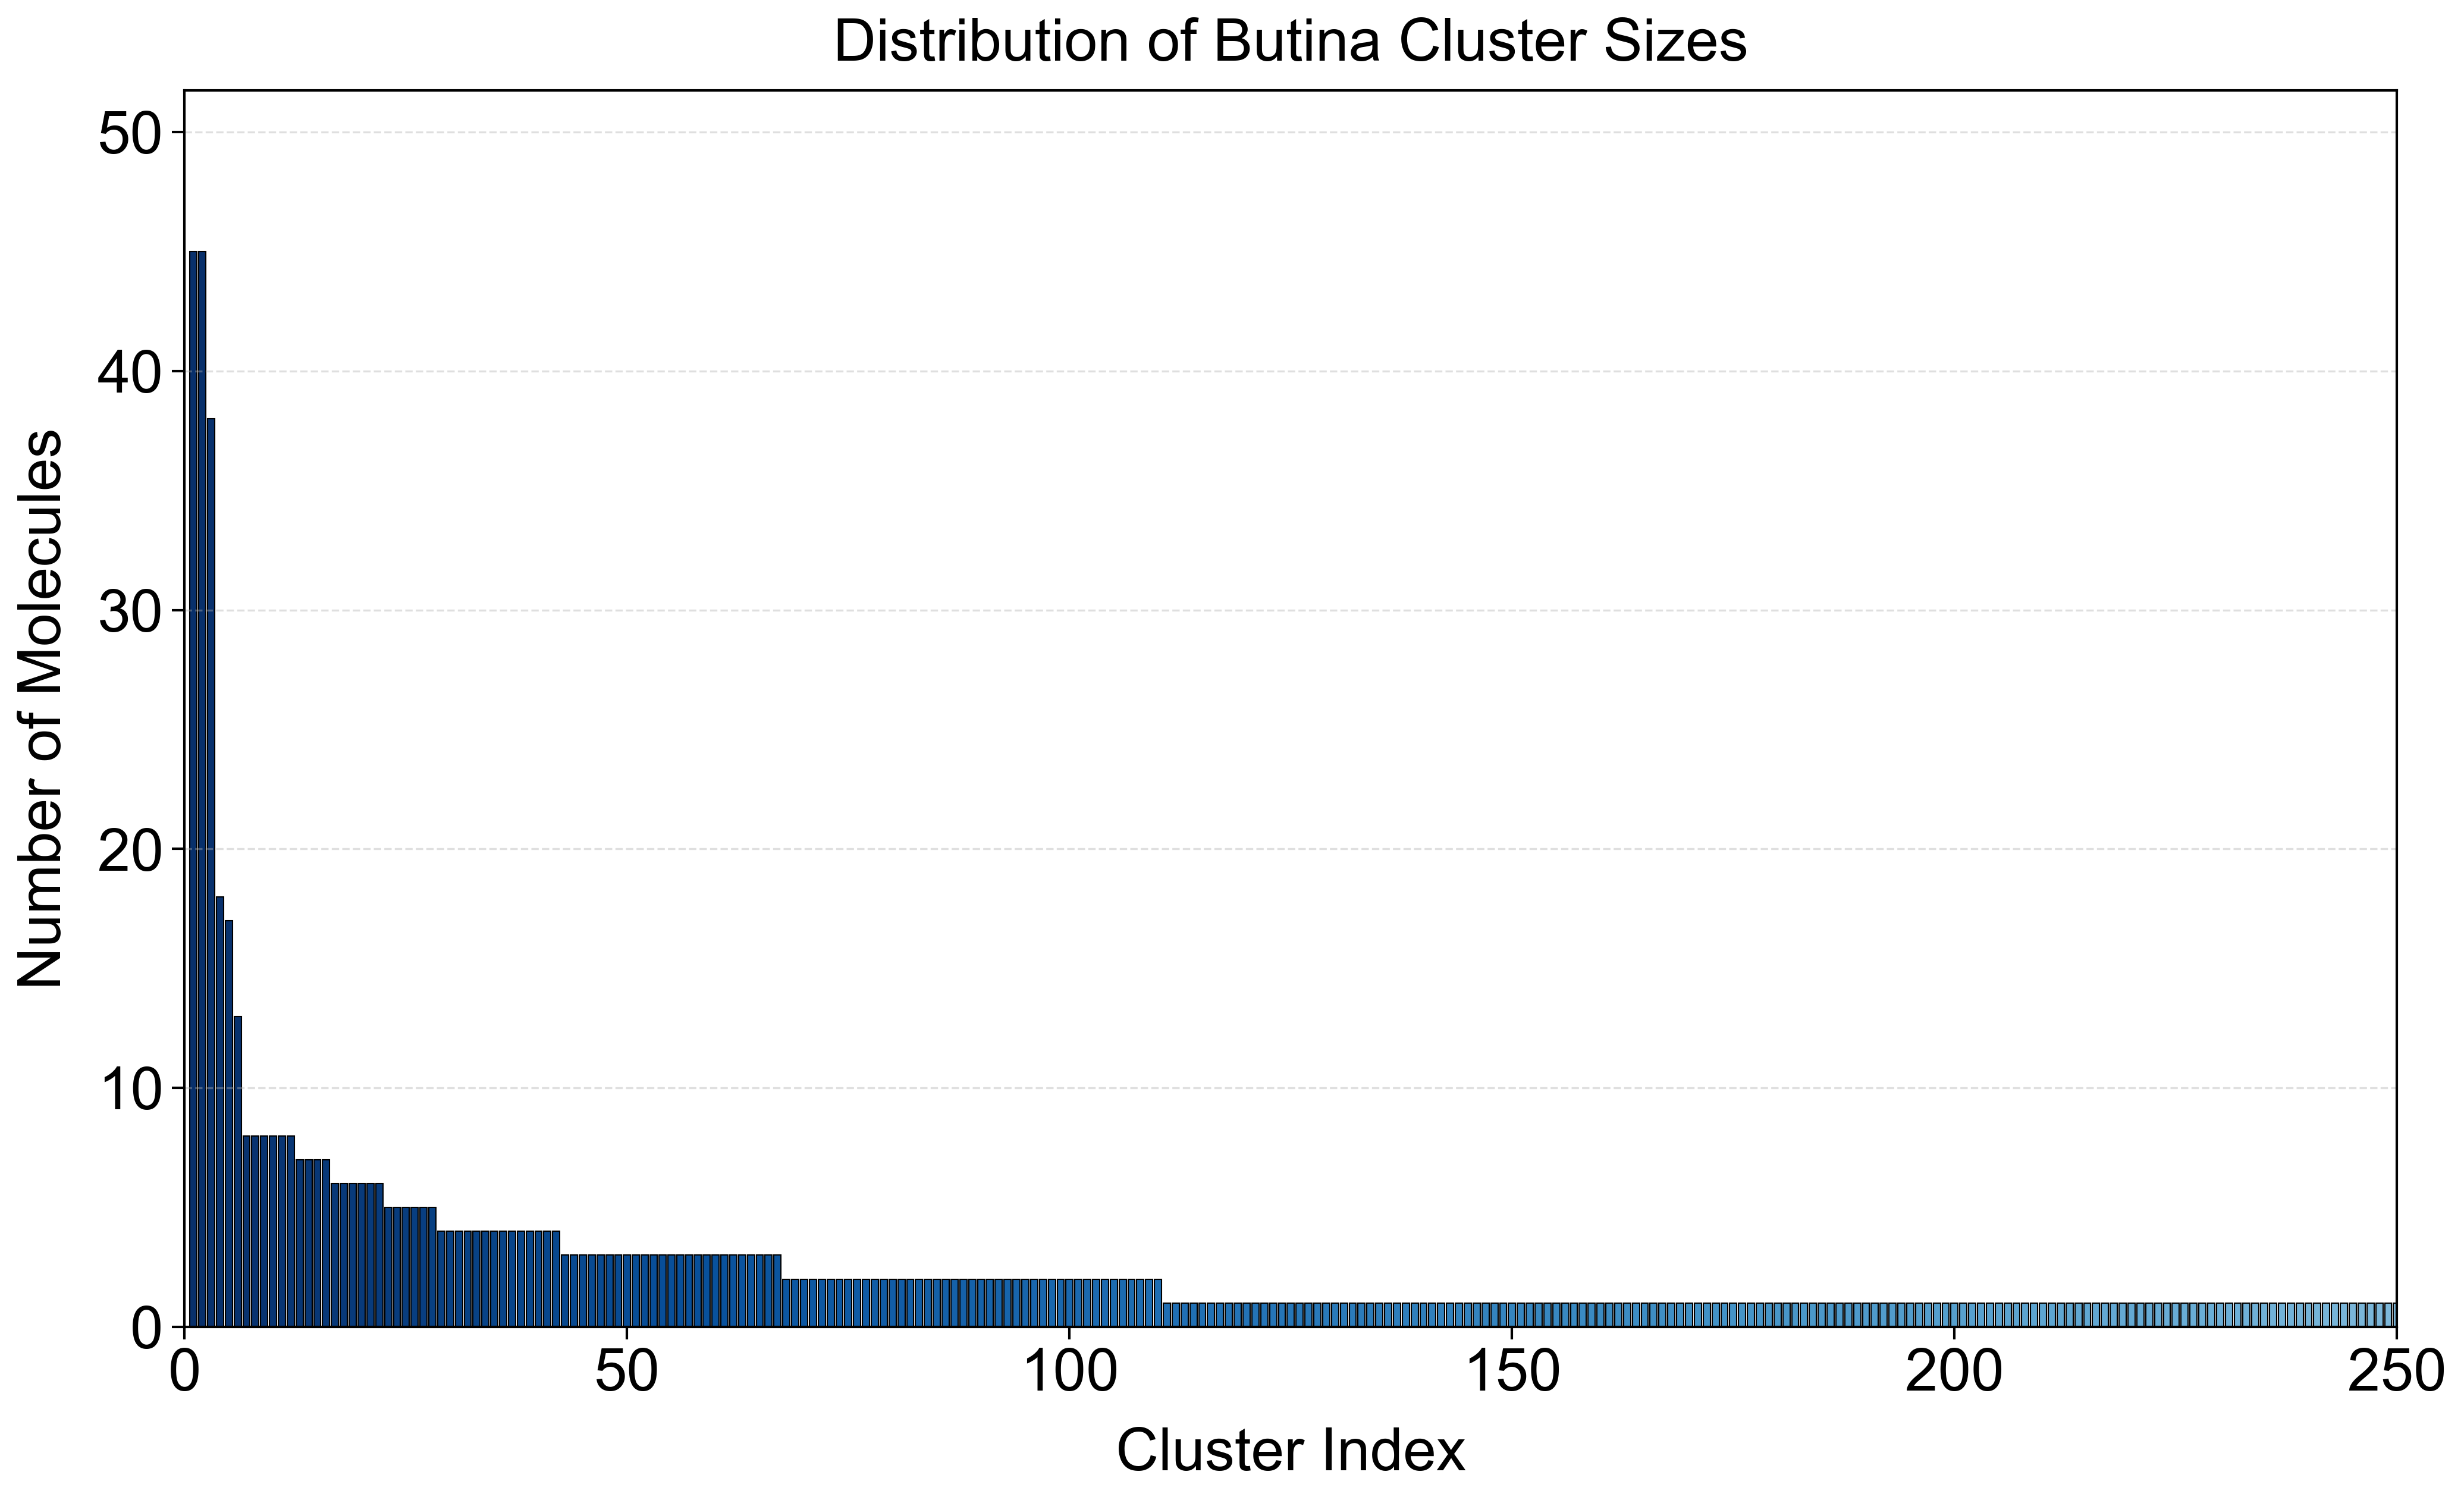

<Figure size 2400x1500 with 0 Axes>

In [23]:
#Visualize clustering results using MDS
clusters = clusterfps(fps, cutoff=0.6)

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
    'axes.grid': False,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'figure.figsize': (8, 5),
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.transparent': True,
    'savefig.bbox': 'tight',
    'legend.frameon': False
})

sizes = [len(c) for c in clusters]
sizes_sorted = sorted(sizes, reverse=True)
colors = plt.cm.Blues(np.linspace(1, 0.4, len(sizes_sorted)))
fig, ax = plt.subplots(figsize=(16, 9))
bars = ax.bar(range(1, len(sizes_sorted) + 1), sizes_sorted, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Cluster Index', fontsize=24, labelpad=10)
ax.set_ylabel('Number of Molecules', fontsize=24, labelpad=10)
ax.set_title('Distribution of Butina Cluster Sizes', fontsize=24, pad=12)
ax.set_ylim(0, max(sizes_sorted) * 1.15)
ax.set_xlim((0, 250))
ax.tick_params(axis='both', which='major', labelsize=24)
ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
#plt.tight_layout()
plt.show()
plt.savefig('./cluster_size_distrribution.png', dpi = 300)

IndexError: string index out of range

<Figure size 1000x1000 with 0 Axes>